In [27]:
library(tidyverse)

library(grid)
library(gridExtra)

source("/home/yuliya/repos/other/removeBatch/evaluation_utils/plots_eda.R")

In [28]:
cbPalette <- c("#861657", "#2A9D8F", "#E76F51", "#E2AFDE", "#0D310C")

# Load data

In [29]:
data_path <- "../evaluation_data/simulated/"

before_correction <- list()
central_corrected <- list()
metadata <- list()

for(mode in c("balanced", "mild_imbalanced", "strong_imbalanced")){
    before_correction[[mode]] <- read.csv(paste0(data_path, mode, "/all_intensities.tsv"), sep = "\t", header = TRUE, row.names = 1, check.names = F)
    central_corrected[[mode]] <- read.csv(paste0(data_path, mode, "/after/intensities_R_corrected.tsv"), sep = "\t", header = TRUE, row.names = 1, check.names = F)
    metadata[[mode]] <- read.csv(paste0(data_path, mode, "/all_metadata.tsv"), sep = "\t", header = TRUE, row.names = 1)

    metadata[[mode]]$file <- rownames(metadata[[mode]])
    metadata[[mode]]$condition <- as.factor(ifelse(metadata[[mode]]$A == 1, "A", "B"))
    metadata[[mode]]$lab <- as.factor(metadata[[mode]]$lab)

    # order the columns in intensity dataframes
    central_corrected[[mode]] <- central_corrected[[mode]][, rownames(metadata[[mode]])]
    before_correction[[mode]] <- before_correction[[mode]][, rownames(metadata[[mode]])]

    cat(mode, "before correction:", nrow(before_correction[[mode]]), "rows\n")
    cat(mode, "after R correction:", nrow(central_corrected[[mode]]), "rows\n")
    cat(mode, "metadata:", nrow(metadata[[mode]]), "rows\n\n")
}

balanced before correction: 6000 rows
balanced after R correction: 6000 rows
balanced metadata: 600 rows

mild_imbalanced before correction: 6000 rows
mild_imbalanced after R correction: 6000 rows
mild_imbalanced metadata: 600 rows

strong_imbalanced before correction: 6000 rows
strong_imbalanced after R correction: 6000 rows
strong_imbalanced metadata: 600 rows



# Checks

## Diagnostic plots

In [30]:
# supress warnings
options(warn=-1)

In [31]:
plot_pca_uncorrected <- list()
plot_pca_corrected <- list()

for(mode in c("balanced", "mild_imbalanced", "strong_imbalanced")){

    before_with_zeros <- before_correction[[mode]][1:200,]
    before_with_zeros[is.na(before_with_zeros)] <- 0
    after_with_zeros <- central_corrected[[mode]][1:200,]
    after_with_zeros[is.na(after_with_zeros)] <- 0

    

    plot_pca_uncorrected[[mode]] <- pca_plot(
        before_with_zeros, metadata[[mode]],
        title = paste("PCA, before, simulated", mode, "data"),
        quantitative_col_name = "file", 
        col_col = "condition", shape_col="lab", show_legend=F, cbPalette=c("#a70a66", "#2a609d"))

    plot_pca_corrected[[mode]] <- pca_plot(
        after_with_zeros, metadata[[mode]],
        title = paste("PCA, after R correction, simulated", mode, "data"),
        quantitative_col_name = "file", 
        col_col = "condition", shape_col="lab", show_legend=T, cbPalette=c("#a70a66", "#2a609d"))
}

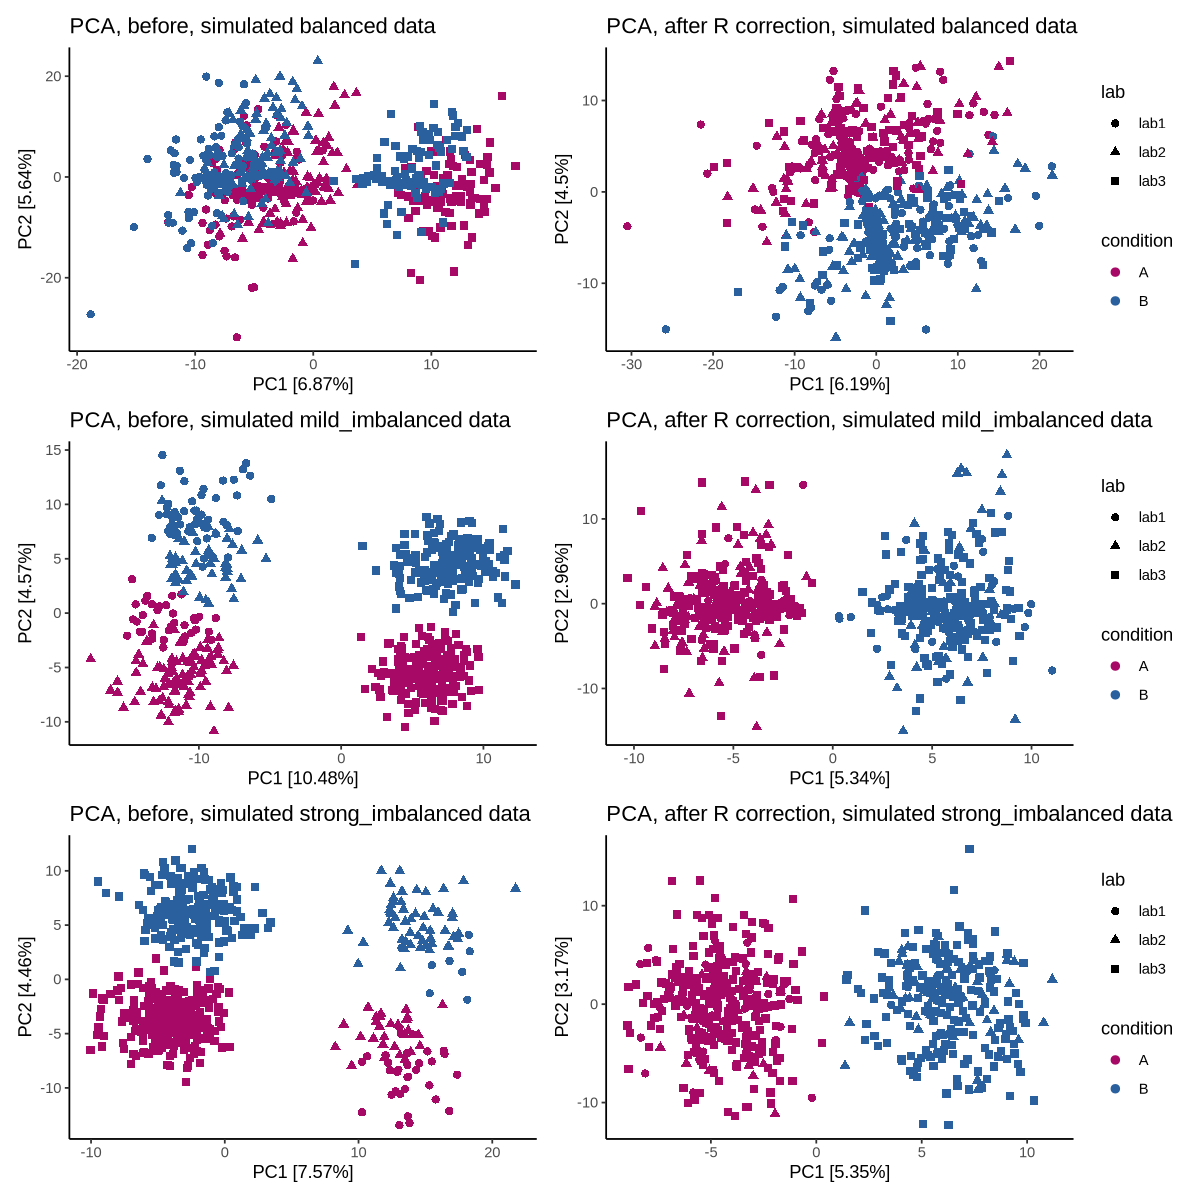

In [32]:
layout <- (plot_pca_uncorrected[["balanced"]] + plot_pca_corrected[["balanced"]]) /
            (plot_pca_uncorrected[["mild_imbalanced"]] + plot_pca_corrected[["mild_imbalanced"]]) /
            (plot_pca_uncorrected[["strong_imbalanced"]] + plot_pca_corrected[["strong_imbalanced"]])

options(repr.plot.width=10, repr.plot.height=10)
layout

In [33]:
violins_uncorrected <- list()
violins_central <- list()

for(mode in c("balanced", "mild_imbalanced", "strong_imbalanced")){

    # # Determine the shared Y-axis limits
    y_min <- min(before_correction[[mode]], central_corrected[[mode]], na.rm = TRUE)
    y_max <- max(before_correction[[mode]], central_corrected[[mode]], na.rm = TRUE)
    y_limits <- c(y_min, y_max)

    violins_uncorrected[[mode]] <- boxplot_plot_groupped(
        before_correction[[mode]], metadata[[mode]], 
        title = paste("data before, simulated", mode),
        quantitativeColumnName = "file",
        color_col = "lab", remove_xnames = T, show_legend=F, y_limits = y_limits, cbPalette = cbPalette)
    
    violins_central[[mode]] <- boxplot_plot_groupped(
        central_corrected[[mode]], metadata[[mode]], 
        title = paste("data after R correction, simulated", mode),
        quantitativeColumnName = "file",
        color_col = "lab", remove_xnames = T, show_legend=F, y_limits = y_limits, cbPalette = cbPalette)
}

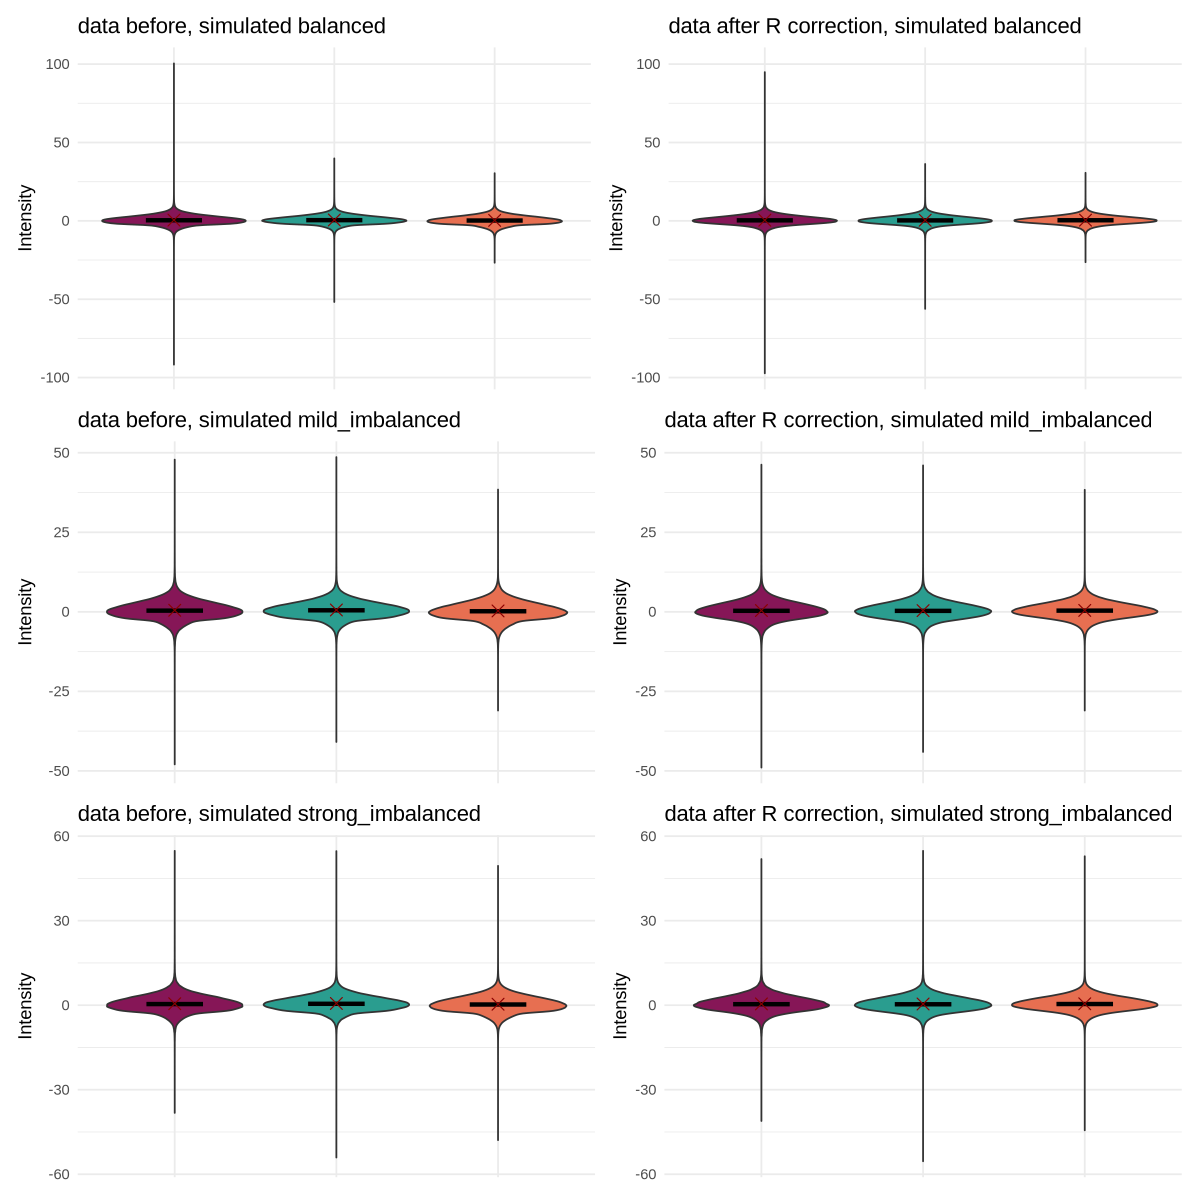

In [35]:
layout <- (violins_uncorrected[["balanced"]] + violins_central[["balanced"]]) /
            (violins_uncorrected[["mild_imbalanced"]] + violins_central[["mild_imbalanced"]]) /
            (violins_uncorrected[["strong_imbalanced"]] + violins_central[["strong_imbalanced"]])
layout  

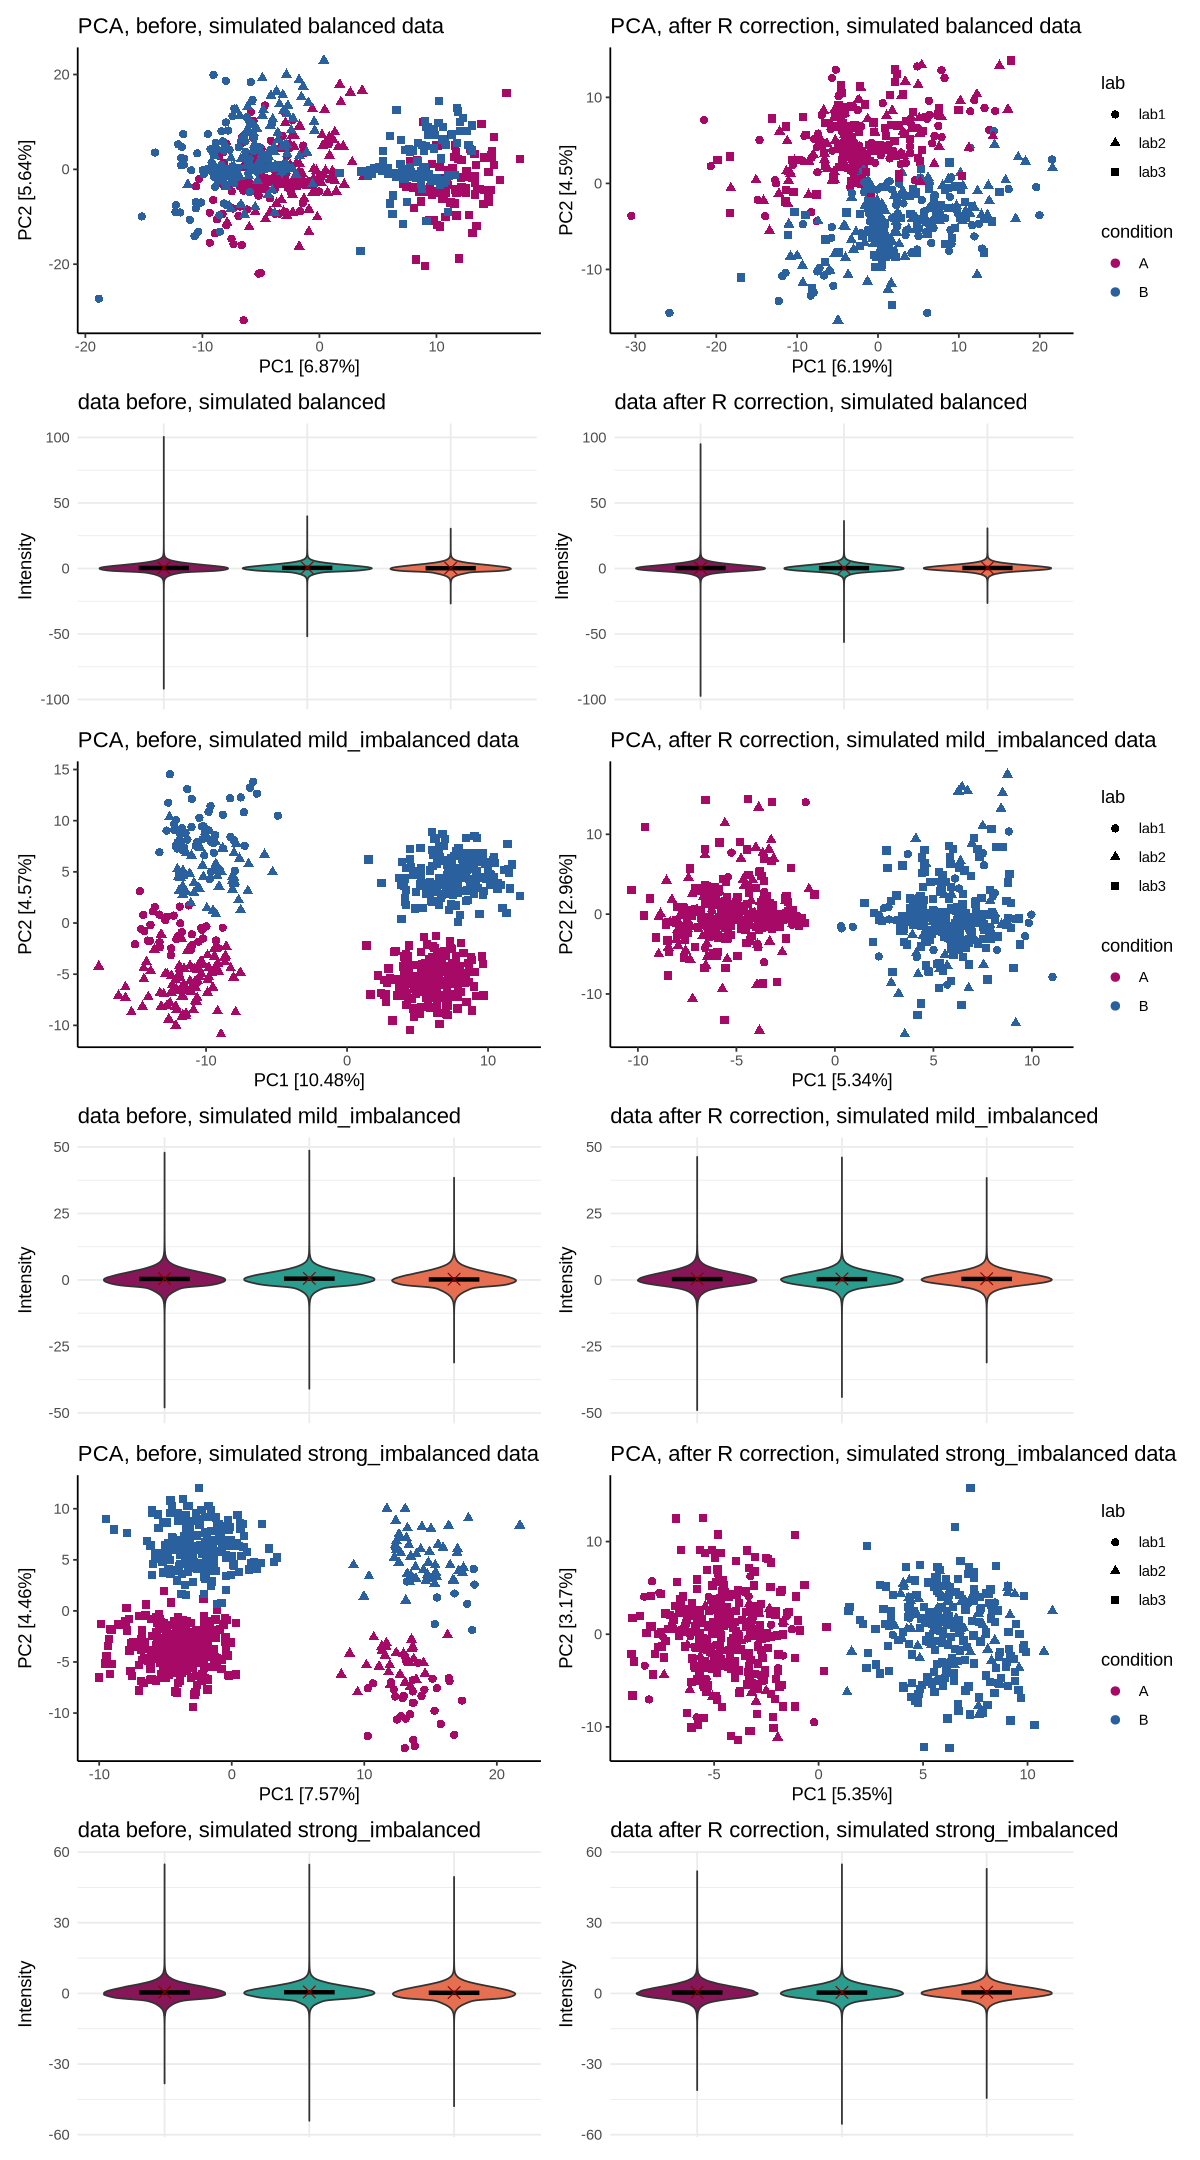

In [36]:
# pca and violins in one
layout <- (plot_pca_uncorrected[["balanced"]] + plot_pca_corrected[["balanced"]]) /
          (violins_uncorrected[["balanced"]] + violins_central[["balanced"]]) /
            (plot_pca_uncorrected[["mild_imbalanced"]] + plot_pca_corrected[["mild_imbalanced"]]) /
            (violins_uncorrected[["mild_imbalanced"]] + violins_central[["mild_imbalanced"]]) /
            (plot_pca_uncorrected[["strong_imbalanced"]] + plot_pca_corrected[["strong_imbalanced"]]) /
            (violins_uncorrected[["strong_imbalanced"]] + violins_central[["strong_imbalanced"]])

options(repr.plot.width=10, repr.plot.height=18)
layout 

##  Linear model per variable

Following batch effect correction, the percentage of variance explained by the condition should be greater than the batch.

In [38]:
library(variancePartition)

Loading required package: limma



Loading required package: BiocParallel


Attaching package: ‘variancePartition’


The following object is masked from ‘package:limma’:

    topTable




In [52]:
lmpv_plot <- function(data, metadata, title, show_legend = T, max_yval=NULL){
    form <- ~ condition + lab

    varPart <- fitExtractVarPartModel(na.omit(data), form, metadata)
    variance_col <- as.matrix(varPart[,1:2])

    df_long <- reshape2::melt(variance_col)

    # Plotting the boxplots using ggplot2
    res_plots <- ggplot(df_long, aes(x = Var2, y = value, fill=Var2)) +
      geom_boxplot() +
      labs(title = title,
           y = "Proportion Variance", x = "Column") +
      scale_fill_discrete(name = "Column") +
      theme_minimal()

  if(!is.null(max_yval)){
    res_plots <- res_plots + ylim(0, max_yval)
  }

  if(!show_legend){
    res_plots <- res_plots + 
    theme(legend.position = "none")
  }

  return(res_plots)
}

In [53]:
lmpv_plot_uncorrected <- list()
lmpv_plots_corrected <- list()

y_limits_values <- list(
    "balanced" = 0.51,
    "mild_imbalanced" = 0.62,
    "strong_imbalanced" = 0.6
)

for(mode in c("balanced", "mild_imbalanced", "strong_imbalanced")){

    before_with_zeros <- before_correction[[mode]][1:200,]
    before_with_zeros[is.na(before_with_zeros)] <- 0
    after_with_zeros <- central_corrected[[mode]][1:200,]
    after_with_zeros[is.na(after_with_zeros)] <- 0

    lmpv_plot_uncorrected[[mode]] <- lmpv_plot(before_with_zeros, metadata[[mode]], paste("LMPV, before, simulated", mode, "data"), show_legend=F, max_yval = y_limits_values[[mode]])
    lmpv_plots_corrected[[mode]] <- lmpv_plot(after_with_zeros, metadata[[mode]], paste("LMPV, after R correction, simulated", mode, "data"), max_yval = y_limits_values[[mode]])
}



Total:0.4 s


Total:0.4 s


Total:0.4 s


Total:0.4 s


Total:0.4 s


Total:0.3 s



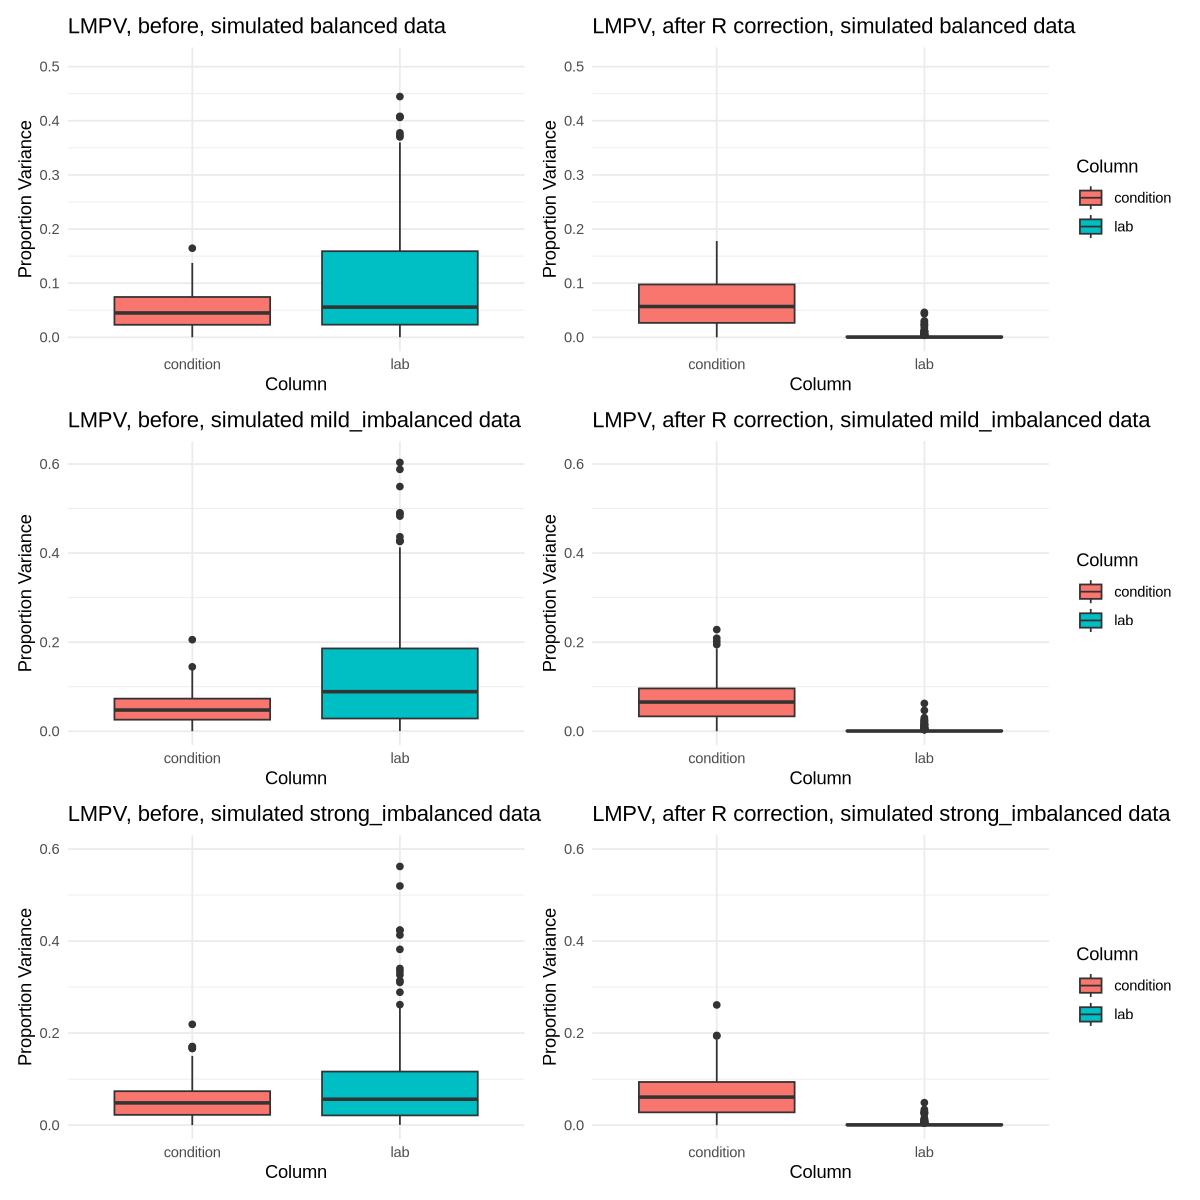

In [54]:
layout <- (lmpv_plot_uncorrected[["balanced"]] + lmpv_plots_corrected[["balanced"]]) /
            (lmpv_plot_uncorrected[["mild_imbalanced"]] + lmpv_plots_corrected[["mild_imbalanced"]]) /
            (lmpv_plot_uncorrected[["strong_imbalanced"]] + lmpv_plots_corrected[["strong_imbalanced"]])

options(repr.plot.width=10, repr.plot.height=10)
layout